In [1]:
import sys
sys.path.append('..')
from load_datasets import get_image_with_bbox, load_cifar10_imgs_and_labels, load_mnist_imgs_and_labels, load_celeba_images, load_adam_image

import numpy as np
import pandas as pd
import seaborn as sns
from torchsummary import summary
from matplotlib import pyplot as plt
from functools import reduce
from itertools import product
flat_map = lambda f, xs: reduce(lambda a, b: a + b, map(f, xs), [])

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, resnet50

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'CUDA enabled: {use_cuda}')

CUDA enabled: True


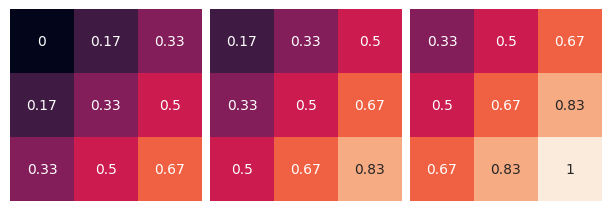

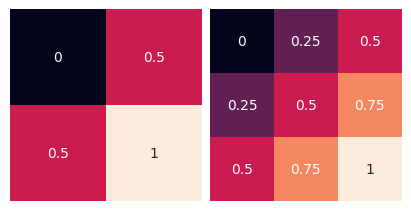

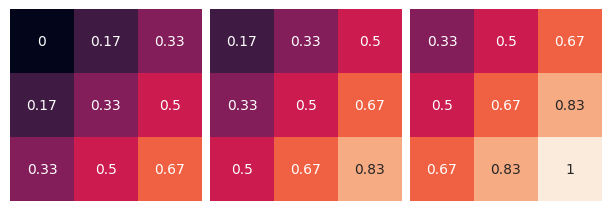

In [ ]:
def fade_tensor(size):
	res = torch.empty(size)
	ranges = [list(range(r)) for r in size]
	for idx in product(*ranges):
		res[idx] = sum(idx) / (sum(size) - len(size))
	return res


def visualise_tensor(tensor, ax=None, scale=2, vector=False, clip=True):
	if ax is None:
		fig, ax = plt.subplots(1,1, constrained_layout=True)
		fig.set_size_inches(scale, (scale / tensor.shape[1]) if vector else scale)

	sns.heatmap(data=tensor, annot=tensor, 
		ax=ax, cbar=False, yticklabels=False, xticklabels=False,
		vmin=0.0 if clip else None, vmax=1.0 if clip else None)


def visualise_tensors(tensor, scale=2, vector=False, clip=True):
	# works also for multiple matrices
	n = len(tensor)
	layout = (n, 1) if vector else (1, n)
	fig, axes = plt.subplots(*layout, constrained_layout=True)
	fig.set_size_inches(scale * n, scale)

	for ax, chan in zip(axes, tensor):
		visualise_tensor(chan, ax=ax, scale=scale, vector=vector, clip=clip)

	return fig


m1 = fade_tensor((2,2))
m2 = fade_tensor((3,3))
visualise_tensors([m1, m2])

ndt = fade_tensor((3,3,3))
visualise_tensors(ndt)

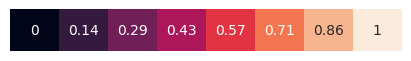

In [ ]:
vec = fade_tensor((8,)).unsqueeze_(0)
visualise_tensor(vec, vector=True, scale=4)

## Pooling visualisation

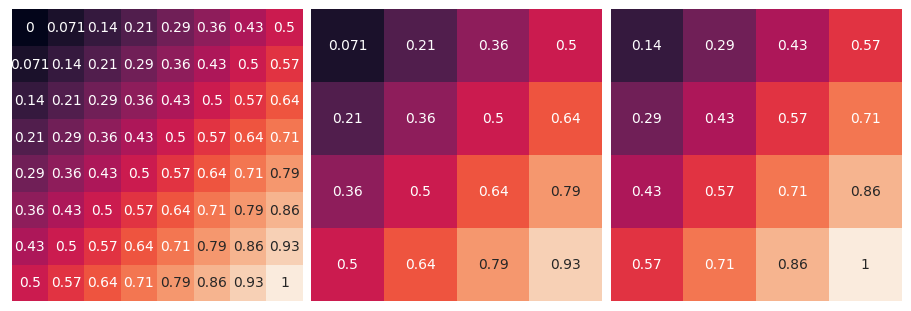

In [ ]:
in_tensor = fade_tensor((8, 8))
avg_pool = nn.AvgPool2d(2, stride=2)
max_pool = nn.MaxPool2d(2, stride=2)

avg_tensor = avg_pool(in_tensor.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
max_tensor = max_pool(in_tensor.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

fig = visualise_tensors([in_tensor, avg_tensor, max_tensor], scale=3)
fig.savefig('../../paper/2.pooling.png')

## Softmax and Argmax visualisation

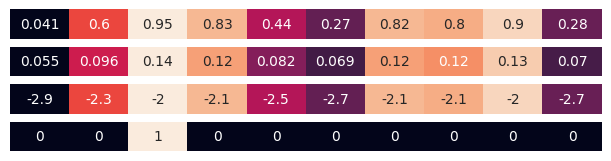

In [ ]:
vector = torch.rand((1, 10))
def argmax(tensor):
	res = torch.zeros(tensor.shape)
	res[0][torch.argmax(tensor, dim=1)] = 1.0
	return res

soft_vec = F.softmax(vector, dim=1)
logs_vec = F.log_softmax(vector, dim=1)
argm_vec = argmax(vector)

fig = visualise_tensors([vector, soft_vec, logs_vec, argm_vec], vector=True, scale=1.5, clip=False)
fig.savefig('../../paper/2.softmax.png')

## Dense layer visualisation
dobra to jest niepotrzebne, to nie jest przedszkole

torch.Size([5, 10])

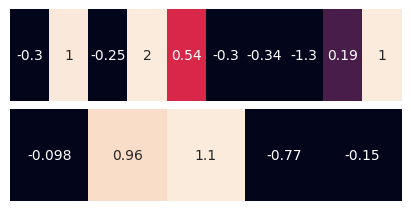

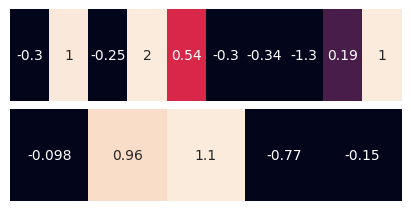

In [ ]:
in_vector = torch.randn((1, 10))
dense = nn.Linear(10, 5)
display(dense.weight.shape)

with torch.no_grad():
	out_vector = dense(in_vector)

visualise_tensors([in_vector, out_vector], vector=True, scale=2)

## Convolution visualisation

torch.Size([8, 8])

torch.Size([4, 1, 4, 4])

torch.Size([4, 9, 9])

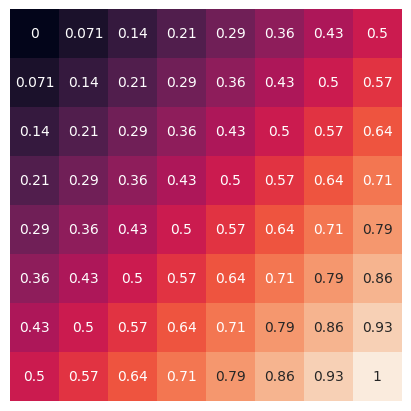

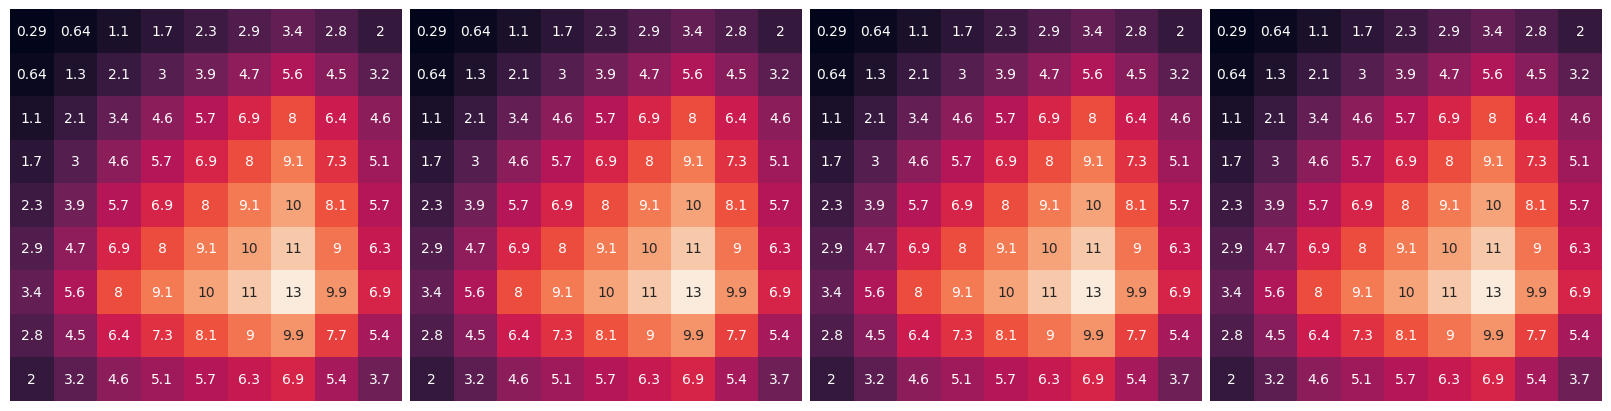

In [ ]:
conv2d = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=1, padding=2, bias=False) # padding='same' equivalent
in_tensor = fade_tensor((8, 8))
# in_tensor = torch.rand((8, 8))

display(in_tensor.shape)
visualise_tensor(in_tensor, scale=4)

with torch.no_grad():
	conv2d.weight = nn.Parameter(torch.ones_like(conv2d.weight))
	out_tensor = conv2d(in_tensor.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

display(conv2d.weight.shape)

display(out_tensor.shape)
_ = visualise_tensors(out_tensor, scale=4, clip=False)

## Softmax, Negative Log Likelihood, Cross Entropy Loss

tensor(2.1655)

tensor(2.1655)

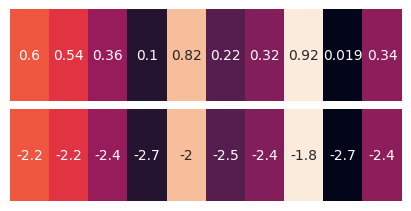

In [ ]:
x = torch.rand((1, 10))
y = torch.tensor([0])

sm = F.log_softmax(x, dim=1)
nll = F.nll_loss(sm, y)
cce = F.cross_entropy(x, y)

visualise_tensors([x, sm], vector=True, scale=2, clip=False)
display(nll)
display(cce)

In [ ]:
target = torch.tensor([0, 2, 1, 3, 2])
logits =  torch.tensor([
    [3.5, -3.45, 0.23, 1.25],
    [-2.14, 0.54, 2.67, -5.23],
    [-1.34, 5.01, -1.54, -1.17],
    [ -2.98, -1.37, 1.54,5.23],
	[ -2.98, 2.37, 1.54,0.23]
])
probs = F.softmax(logits, dim=1)
log_probs = np.log(F.softmax(logits, dim=1)) # F.log_softmax(logits, dim=1) equivalent

# get log_prob for desired class for each sample (and invert sign)
own_nll = -(log_probs[range(len(target)), target])  

# compare with pytorch implementation
bib_nll = F.nll_loss(log_probs, target, reduction='none')
red_bib_nll = F.nll_loss(log_probs, target)

display(own_nll)
display(bib_nll)

own_nll.mean(), red_bib_nll

tensor([0.1348, 0.1199, 0.0052, 0.0263, 1.2737])

tensor([0.1348, 0.1199, 0.0052, 0.0263, 1.2737])

(tensor(0.3120), tensor(0.3120))

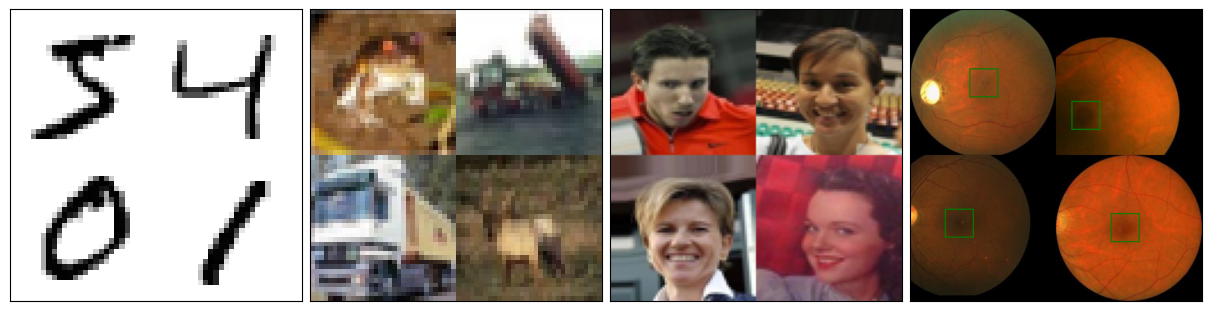

In [152]:
# mnist 

mnist, _ = load_mnist_imgs_and_labels(
  '../../datasets/mnist-digits/train-images-idx3-ubyte',
  '../../datasets/mnist-digits/train-labels-idx1-ubyte'
)
mnist = list(map(lambda x: x.reshape(28, 28), mnist[:4]))
mnist = np.concatenate([
	np.concatenate(mnist[:2]),
	np.concatenate(mnist[2:]),
], axis=1)

# cifar-10 

cifar, _ = load_cifar10_imgs_and_labels('../../datasets/cifar-10-py/cifar-10-batches-py/data_batch_1')
cifar = np.concatenate([
	np.concatenate(cifar[:2]),
	np.concatenate(cifar[2:4]),
], axis=1)

# celeb-a

celeba_iter = load_celeba_images('../../datasets/celeba_tiny/img_align_celeba/')
celeba = []
for face in zip(celeba_iter, range(4)):
	face = face[0].resize((64, 64))
	face = np.array(face)
	celeba.append(face)
celeba = np.concatenate([
	np.concatenate(celeba[:2]),
	np.concatenate(celeba[2:]),
], axis=1)

# adam

root = '../../datasets/ADAM/Training1200'
fovea = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')
to_draw = np.random.choice(fovea.index, size=4, replace=False)

adam = []
for i in to_draw:
	img, bbox = load_adam_image(fovea, i)
	res = get_image_with_bbox(fovea, img, bbox)
	adam.append(np.array(res))
adam = np.concatenate([
	np.concatenate(adam[:2]),
	np.concatenate(adam[2:]),
], axis=1)

# draw

fig, axes = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(12, 3)

for ax in axes:
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

axes[0].imshow(mnist, cmap='gray')
axes[1].imshow(cifar)
axes[2].imshow(celeba)
axes[3].imshow(adam)

fig.savefig('../../paper/4.datasets.png')